In [458]:
from dotenv import load_dotenv
load_dotenv()

True

In [459]:
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
llm=ChatGroq(model_name="deepseek-r1-distill-llama-70b")
model = ChatOpenAI()

In [460]:
#response = model.invoke("what is sun parma company?")
import random

In [461]:
response ="Sun Pharma is an Indian multinational pharmaceutical company headquartered in Mumbai, Maharashtra. It is the largest pharmaceutical company in India and one of the largest pharmaceutical companies in the world. Sun Pharma manufactures and sells a wide range of pharmaceutical products in various therapeutic areas including dermatology, cardiology, neurology, and ophthalmology."


In [462]:
from typing import Literal
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command

In [463]:
class State(MessagesState):
    next:str
#state={"messages": ["hi"], "next": "research_agent"}

In [464]:
#print(state)
from langchain_core.messages import HumanMessage

In [465]:
import json
import re
def team_1_supervisor(state: State) -> Command[Literal["team_1_agent_1", "team_1_agent_2", END]]:
    print("**********team_1_supervisor***************")
    print(state["messages"][0])
    if len(state["messages"]) == 1:
        print(state) 
        customer_question = state["messages"][0]
        prompt = f"""
        You are an intelligent assistant responsible for analyzing a customer's question and routing it to the correct specialist team.

        Your task is to:
        1. Determine if the question is about:
        - **Medical / Pharmaceutical** → respond with `"next": "team_1_agent_1"`
        - **Financial** → respond with `"next": "team_1_agent_2"`
        - **General Research** → respond with `"next": "END"` and include a detailed explanation (at least 10 lines) in `"message"`

        ❗Respond STRICTLY in JSON format with no commentary, no <think>, and no markdown.

        The format must be:

        {{
        "next": "team_1_agent_1" | "team_1_agent_2" | "END",
        "message": "<brief explanation or detailed info>"
        }}

        Customer question:
        "{customer_question}"
        """

        # Fill the prompt with the customer question
        #filled_prompt = prompt.format(customer_question=customer_question)
        response =llm.invoke([HumanMessage(content=prompt)]).content.strip()
        try:
            match = re.search(r'\{.*\}', response, re.DOTALL)
            if not match:
                raise ValueError("No JSON object found in LLM response.")
            
            json_text = match.group(0)
            parsed = json.loads(json_text)
            next_node = parsed["next"]
            message = parsed["message"]

            print(f"Next: {next_node}")
            print(f"Message: {message}")
            return Command(goto=next_node, update={"messages": state["messages"] + [message]})

        except Exception as e:
            print("❌ Failed to parse LLM response:", e)
            return Command(goto=END, update={"messages": state["messages"] + ["LLM parsing failed"]})
    else:
        #print("Prepare Report")
        return Command(goto=END, update={"messages": state["messages"] + ["Prepare report"]})  



In [466]:

team_1_supervisor({'messages': ["What is the current gdp of the india?"], 'next': 'top_level_supervisor'})

**********team_1_supervisor***************
What is the current gdp of the india?
{'messages': ['What is the current gdp of the india?'], 'next': 'top_level_supervisor'}


Next: team_1_agent_2
Message: The question is about GDP, which is a financial topic.


Command(update={'messages': ['What is the current gdp of the india?', 'The question is about GDP, which is a financial topic.']}, goto='team_1_agent_2')

In [467]:
class Statess(MessagesState):
    next: Literal["team_1_agent_1", "team_1_agent_1", "__end__"]

In [468]:
def team_1_agent_1(state: State) -> Command[Literal["team_1_supervisor"]]:
    print("**********team_1_agent1***************")
    
    # options = {"team_1_supervisor", END}
    # # Pick one random value
    # selected = random.choice(list(options))
    # response ={"next":selected}
    # goto = response["next"]
    customer_question = state["messages"][0]
    prompt = f"""
    You are a highly skilled medical expert assigned to analyze customer MEDICAL/PHRAMA inquiries and provide a comprehensive, detailed report.

    Your responsibilities include:
    1. Carefully review the customer's question.
    2. If the question is MEDICAL/PHRAMA in nature, respond with:
    - "next": "team_1_supervisor"
    - "message": a detailed medical analysis or report based on the question (minimum 10 lines).
    3. If the question is unrelated or contains insufficient/invalid content, respond with:
    - "next": "END"
    - "message": a brief explanation of why the input could not be processed.

    ⚠️ You must respond **strictly** in valid JSON format with **no extra commentary**, no `<think>` tags, and no markdown.

    Expected response format:
    {{
    "next": "team_1_supervisor" | "END",
    "message": "<detailed financial report or error explanation>"
    }}

    Customer question:
    "{customer_question}"
    """

    # Fill the prompt with the customer question
    #filled_prompt = prompt.format(customer_question=customer_question)
    response =llm.invoke([HumanMessage(content=prompt)]).content.strip()
    print(f"response of T1A1 :  {response}")
    try:
        match = re.search(r'\{.*\}', response, re.DOTALL)
        if not match:
            raise ValueError("No JSON object found in LLM response.")
        
        json_text = match.group(0)
        parsed = json.loads(json_text)
        next_node = parsed["next"]
        message = parsed["message"]

        print(f"Next: {next_node}")
        print(f"Message: {message}")
        return Command(goto=next_node, update={"messages": state["messages"] + [message]})

    except Exception as e:
        print("❌ Failed to parse LLM response:", e)
        return Command(goto=END, update={"messages": state["messages"] + ["LLM parsing failed"]})
    
    return Command(goto=goto, update=state)

In [469]:
def team_1_agent_2(state: State) -> Command[Literal["team_1_supervisor"]]:
    print("**********team_1_agent2***************")
    for msg in state['messages']:
        print(f"Message \n {msg}")
    customer_question = state["messages"][0]
    prompt = f"""
    You are a highly skilled financial expert assigned to analyze customer financial inquiries and provide a comprehensive, detailed report.

    Your responsibilities include:
    1. Carefully review the customer's question.
    2. If the question is financial in nature, respond with:
    - "next": "team_1_supervisor"
    - "message": a detailed financial analysis or report based on the question (minimum 10 lines).
    3. If the question is unrelated or contains insufficient/invalid content, respond with:
    - "next": "END"
    - "message": a brief explanation of why the input could not be processed.

    ⚠️ You must respond **strictly** in valid JSON format with **no extra commentary**, no `<think>` tags, and no markdown.

    Expected response format:
    {{
    "next": "team_1_supervisor" | "END",
    "message": "<detailed financial report or error explanation>"
    }}

    Customer question:
    "{customer_question}"
    """

    # Fill the prompt with the customer question
    #filled_prompt = prompt.format(customer_question=customer_question)
    response =llm.invoke([HumanMessage(content=prompt)]).content.strip()
    print(f"response of T1A2 :  {response}")
    try:
        match = re.search(r'\{.*\}', response, re.DOTALL)
        if not match:
            raise ValueError("No JSON object found in LLM response.")
        
        json_text = match.group(0)
        parsed = json.loads(json_text)
        next_node = parsed["next"]
        message = parsed["message"]

        print(f"Next: {next_node}")
        print(f"Message: {message}")
        return Command(goto=next_node, update={"messages": state["messages"] + [message]})

    except Exception as e:
        print("❌ Failed to parse LLM response:", e)
        return Command(goto=END, update={"messages": state["messages"] + ["LLM parsing failed"]})
    # options = {"team_1_supervisor", "END"}
    # # Pick one random value
    # selected = random.choice(list(options))
    # response ={"next":selected}
    # goto = response["next"] 

In [470]:
# team_1_agent_2()

In [471]:
team_1_builder = StateGraph(State) 
team_1_builder.add_node(team_1_supervisor)
team_1_builder.add_node("team_1_agent_1",team_1_agent_1)
team_1_builder.add_node("team_1_agent_2",team_1_agent_2)
team_1_builder.add_edge(START, "team_1_supervisor")
team_1_graph = team_1_builder.compile()

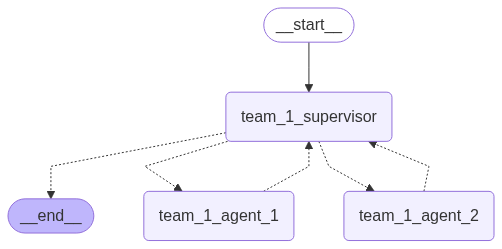

In [472]:
from IPython.display import Image, display
display(Image(team_1_graph.get_graph().draw_mermaid_png()))

In [473]:
class Team2State(State):
    next: Literal["team_2_agent_1", "team_2_agent_2", "__end__"]

In [474]:
def team_2_supervisor(state: State) -> Command[Literal["team_2_agent_1", "team_2_agent_2",END]]:
    print("**********team_2_supervisor***************")
    #  #response = model.invoke(...)
    # options = {"team_2_agent_1", "team_2_agent_2",END}
    # # Pick one random value
    # selected = random.choice(list(options))
    # response ={"next":selected}
    # goto = response["next"]
    last_message = state["messages"][-1]
    if hasattr(last_message, "content"):
        content = last_message.content.lower()
        print(f"lastmessage :{content}") 
        normalized_content = content.lower().strip()
        if "summary" in normalized_content:
            print("goto team_2_agent_2")
            return Command(goto="team_2_agent_2", update=state)
        elif "report generated" in normalized_content or "report gendrated" in normalized_content:
            print("goto END")
            return Command(goto=END, update=state)
        elif "prepare report" in normalized_content:
            print("goto team_2_agent_1")
            return Command(goto="team_2_agent_1", update=state)
        else:
            print("Unrecognized content. Defaulting to END.")
            return Command(goto=END, update=state)

    else:
        print("Unrecognized content. Defaulting to END.")
        return Command(goto=END, update=state)
    

In [475]:
def team_2_agent_1(state: State) -> Command[Literal["team_2_supervisor"]]:
    print("**********team_2_agent1***************")
    # options = {"team_2_supervisor",END}
    # # Pick one random value
    # selected = random.choice(list(options))
    # response ={"next":selected}
    # goto = response["next"]  
    last_message = state["messages"][-1]
    question = last_message.content if hasattr(last_message, "content") else str(last_message)

    
    # Prompt template
    prompt = f"""
    You are a financial assistant.

    Based on the following customer question, write a detailed financial summary report with insights, implications, and recommended next steps.

    Customer Question:
    \"\"\"{question}\"\"\"

    Make sure the report is clear, professional, and about 8–10 lines long.
    Return ONLY the summary with no intro, no markdown, and no extra tags.
    """

    # Call the LLM
    response = llm.invoke([HumanMessage(content=prompt)])
    summary = response.content.strip()

    print("✅ Generated Summary:\n", summary)

    # Update state with new message (summary)
    return Command(
        goto="team_2_supervisor",
        update={"messages": state["messages"] + [summary]}
    )

In [476]:
from fpdf import FPDF
from docx import Document
from datetime import datetime 
from typing import Literal

def team_2_agent_2(state: State) -> Command[Literal["team_2_supervisor"]]:
    print("**********team_2_agent2***************") 
    # options = {"team_2_supervisor",END}
    # # Pick one random value
    # selected = random.choice(list(options))
    # response ={"next":selected}
    # goto = response["next"]
    # Get the latest message (summary)
    summary = state["messages"][-3]
    print(f"message {summary} ")
    if hasattr(summary, "content"):
        summary_text = summary.content
    else:
        summary_text = str(summary)

    # Timestamped filename
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    pdf_filename = f"report_{timestamp}.pdf"
    docx_filename = f"report_{timestamp}.docx"

    # Create PDF
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    for line in summary_text.split('\n'):
        pdf.multi_cell(0, 10, line)
    pdf.output(pdf_filename)
    print(f"✅ PDF saved as {pdf_filename}")

    # Create Word Document
    doc = Document()
    doc.add_heading("Summary Report", 0)
    doc.add_paragraph(summary_text)
    doc.save(docx_filename)
    print(f"✅ Word Doc saved as {docx_filename}")

    # Return control with update
    return Command(
        goto="team_2_supervisor",
        update={"messages": state["messages"] + ["Report generated"]}
    )

In [477]:
# input_state = AgentState(
#     messages=["I'm traveling from India to Japan on 12–14 June 2026"],
#     fetch_info={'status': 'success', 'data': {'cityfrom': 'India', 'cityto': 'Japan', 'days': 3, 'traveldate': 'June 12-14, 2026'}},
#     hotel_info=None,
#     weather_info=None,
#     attraction_info=None,
#     currency_info=None,
#     error=None
# )
# response = get_attraction(input_state)
# print(response)

In [478]:
team_2_builder = StateGraph(State) 
team_2_builder.add_node(team_2_supervisor)
team_2_builder.add_node(team_2_agent_1)
team_2_builder.add_node(team_2_agent_2)
team_2_builder.add_edge(START, "team_2_supervisor")
team_2_graph = team_2_builder.compile()

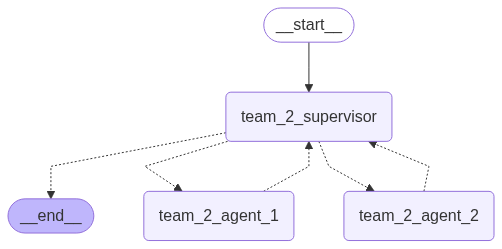

In [479]:
from IPython.display import Image, display
display(Image(team_2_graph.get_graph().draw_mermaid_png()))

In [480]:
builder = StateGraph(Team2State)

In [481]:
def top_level_supervisor(state: State) -> Command[Literal["team_1_graph", "team_2_graph", END]]:
    print("**********Top Supervisor***************")
    # goto = "team_1_graph" 
    print(state['messages'][-1].content) 
    last_message = state['messages'][-1].content

    if(len(state["messages"]) ==1):
        goto= "team_1_graph"
        state["next"]= "team_1_graph"
        print(goto) 
        return Command(goto=goto, update=state)
    elif hasattr(last_message, "content"):
        print(f"check content {last_message}")
        content = last_message.content.lower()
        if "report gendrated" == content:
            print("✅ The message contains 'report gendrated'")
            goto= END
            state["next"]= END
            print(goto) 
            return Command(goto=goto, update=state)
        elif "Prepare report" == content:
            goto= "team_2_graph"
            state["next"]= "team_2_graph"
            print(goto) 
            return Command(goto=goto, update=state)

        # If the message is just a string
    elif isinstance(last_message, str):
        print(f"check str {last_message}")
        content = last_message.lower().strip() 
        print(f"check str lower{last_message}")
        if "Prepare report" == content:
            print(f"check str {content}")
            goto= "team_2_graph"
            state["next"]= "team_2_graph"
            print(goto) 
            return Command(goto=goto, update=state)
        elif "report gendrated" == content:
            print("✅ The message contains 'report gendrated'")
            goto= END
            state["next"]= END
            print(goto) 
            return Command(goto=goto, update=state)
        else:
            print("✅ The message contains 'gendrat report'")
            goto= "team_2_graph"
            state["next"]= "team_2_graph"
            print(goto) 
            return Command(goto=goto, update=state)

    #isBool = True
    # options = {"team_1_graph", "team_2_graph",END}
    # # Pick one random value
    # # selected = random.choice(list(options))
    # response ={"next":selected} 
    # goto = response["next"] 
    
    # route to one of the teams or exit based on the supervisor's decision
    # if the supervisor returns "__end__", the graph will finish execution
    


In [482]:
print(response)

Sun Pharma is an Indian multinational pharmaceutical company headquartered in Mumbai, Maharashtra. It is the largest pharmaceutical company in India and one of the largest pharmaceutical companies in the world. Sun Pharma manufactures and sells a wide range of pharmaceutical products in various therapeutic areas including dermatology, cardiology, neurology, and ophthalmology.


In [483]:
builder = StateGraph(State)
builder.add_node(top_level_supervisor)
builder.add_node("team_1_graph", team_1_graph)
builder.add_node("team_2_graph", team_2_graph)
builder.add_edge(START, "top_level_supervisor")
builder.add_edge("team_1_graph", "top_level_supervisor")
builder.add_edge("team_2_graph", "top_level_supervisor")
graph = builder.compile()

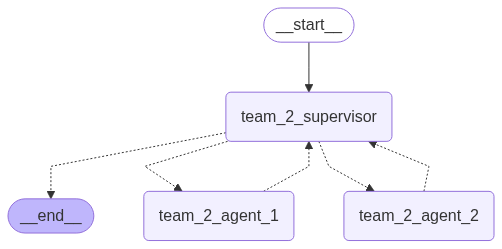

In [484]:
from IPython.display import Image, display
display(Image(team_2_graph.get_graph().draw_mermaid_png()))

In [485]:
graph.invoke({"messages":["What is the panadol?"],"next":"top_level_supervisor"}, config={
        "recursion_limit": 10,
        "debug": True
    })

**********Top Supervisor***************
What is the panadol?
team_1_graph
**********team_1_supervisor***************
content='What is the panadol?' additional_kwargs={} response_metadata={} id='d3299e81-7a9f-41b2-815c-d052f29c6b65'
{'messages': [HumanMessage(content='What is the panadol?', additional_kwargs={}, response_metadata={}, id='d3299e81-7a9f-41b2-815c-d052f29c6b65')], 'next': 'team_1_graph'}
Next: team_1_agent_1
Message: The question is about Panadol, which is a medication.
**********team_1_agent1***************


response of T1A1 :  <think>
Okay, so I need to figure out what the user is asking about. They wrote, "What is the panadol?" I know that Panadol is a brand name for a medication, but I'm not exactly sure which one. I think it's related to pain relief. Let me try to recall. I believe Panadol is a common over-the-counter drug used to relieve headaches, fever, and other minor aches. 

Wait, isn't Panadol actually the brand name for paracetamol? Paracetamol is also known as acetaminophen in some countries. So, Panadol is just the brand name used in certain regions. I should confirm that. Yes, in many places like the UK, Australia, and parts of Asia, paracetamol is sold under the brand name Panadol. 

Now, considering the user's question, they might be asking about the active ingredient, uses, or perhaps the dosage. Since they just asked "What is the panadol?" it's a bit broad. They might be seeking a basic explanation. 

I should explain that Panadol is a brand name for paracetamol, which i

GraphRecursionError: Recursion limit of 10 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT